In [49]:
library(dplyr)
library(tidyr)
library(glmnet)
library(ggplot2)

In [50]:
# Load data

Rivian <- read.csv("Rivian.csv", header = TRUE)
Rivian <- na.omit(Rivian)
head(Rivian)
summary(Rivian)


ID,WTP,gender,age,urban,income_1,liberal_1
1,72249.92,2,44,2,4,4
2,173915.49,2,32,1,7,7
3,154647.89,2,35,1,6,6
4,168845.07,1,35,2,6,6
5,145014.08,2,23,2,7,5
6,128281.69,2,45,2,4,5


       ID              WTP             gender           age       
 Min.   :  1.00   Min.   :     0   Min.   :1.000   Min.   :19.00  
 1st Qu.: 69.25   1st Qu.:105592   1st Qu.:1.000   1st Qu.:32.00  
 Median :135.50   Median :150592   Median :2.000   Median :32.00  
 Mean   :135.26   Mean   :129343   Mean   :1.699   Mean   :35.01  
 3rd Qu.:201.75   3rd Qu.:165042   3rd Qu.:2.000   3rd Qu.:38.00  
 Max.   :273.00   Max.   :180000   Max.   :2.000   Max.   :77.00  
     urban          income_1       liberal_1    
 Min.   :1.000   Min.   :1.000   Min.   :1.000  
 1st Qu.:1.000   1st Qu.:4.000   1st Qu.:5.000  
 Median :1.000   Median :6.000   Median :6.000  
 Mean   :1.534   Mean   :5.267   Mean   :5.549  
 3rd Qu.:2.000   3rd Qu.:6.000   3rd Qu.:6.000  
 Max.   :3.000   Max.   :7.000   Max.   :7.000  

In [51]:
# Run a regression with "vote02" as the outcome variable, and "contact" as the regressor. 
Rivian_Model <- lm(WTP ~ gender + age + urban + income_1 + liberal_1, data = Rivian)
# first variable is outcome, all after tilda are input variables
summary(Rivian_Model)


Call:
lm(formula = WTP ~ gender + age + urban + income_1 + liberal_1, 
    data = Rivian)

Residuals:
    Min      1Q  Median      3Q     Max 
-124902   -7823    8690   21217  128571 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  18551.9    19605.3   0.946   0.3449    
gender        4280.3     5091.8   0.841   0.4013    
age           -416.4      283.9  -1.467   0.1437    
urban        -6263.3     3167.6  -1.977   0.0491 *  
income_1     15746.6     1678.8   9.379  < 2e-16 ***
liberal_1     8067.5     1695.3   4.759 3.23e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 37440 on 260 degrees of freedom
Multiple R-squared:  0.4717,	Adjusted R-squared:  0.4615 
F-statistic: 46.43 on 5 and 260 DF,  p-value: < 2.2e-16


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


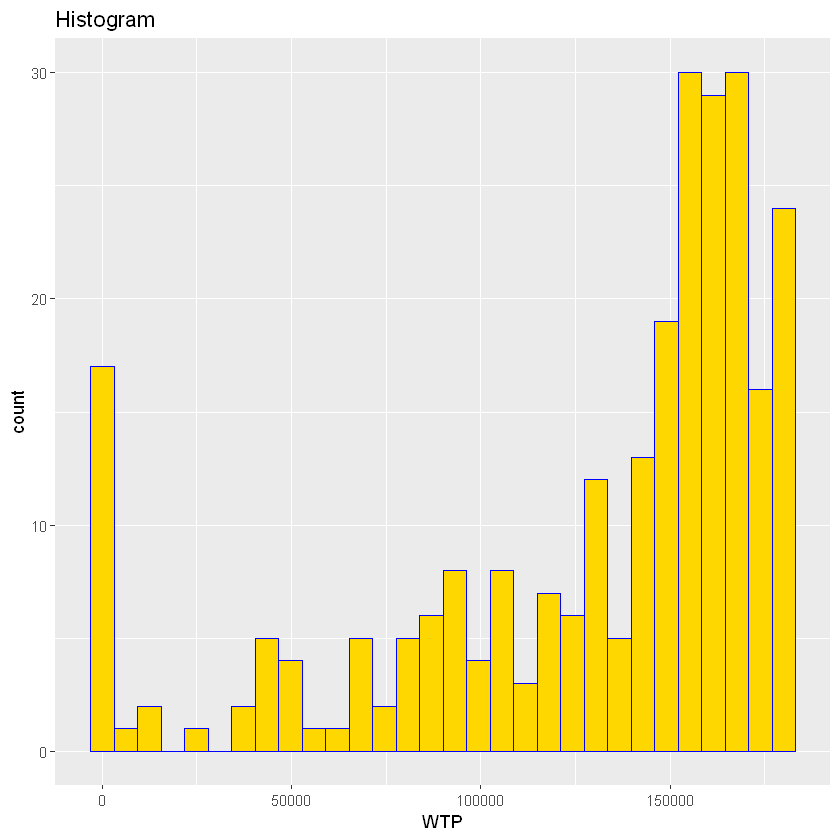

In [52]:
#histogram of Willingness to Pay
ggplot(Rivian, aes(x = WTP)) + geom_histogram(color="blue",fill="gold") + ggtitle("Histogram")

In [70]:
set.seed(1)
# Create train and test sets (50% for training, 50% for testing)
train_rows <- sample(1:nrow(Rivian), nrow(Rivian)/2)
train <- Rivian[train_rows,]
test <- Rivian[-train_rows,]
y <- Rivian$WTP
# Create the outcome variable and the input variables
# y is the outcome variable, x is the input variables
x <- Rivian %>% select(gender, age, urban, income_1, liberal_1)
y_train <- y[train_rows]
x_train <- x[train_rows, ]
y_test <- y[-train_rows]
x_test <- x[-train_rows, ]
head(y)
head(x)

[1]  72249.92 173915.49 154647.89 168845.07 145014.08 128281.69

gender,age,urban,income_1,liberal_1
2,44,2,4,4
2,32,1,7,7
2,35,1,6,6
1,35,2,6,6
2,23,2,7,5
2,45,2,4,5


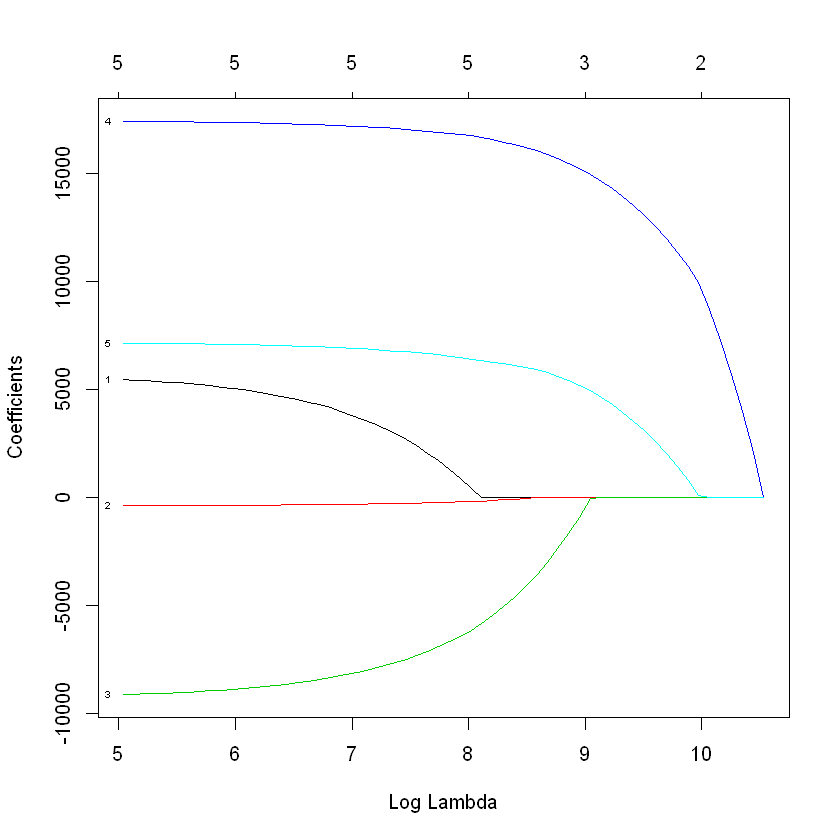

In [62]:
#Fit to full dataset with chosen lambda, examine coefficients
lasso_train <- glmnet(as.matrix(x_train), y_train, alpha=1) #alpha = 1 means lasso.

#Examine coefficients as lambda increases
plot(lasso_train, xvar = "lambda", label = TRUE) 
#graph shows the coefficient for any given lambda. The larger lambda is, the smaller each coefficient gets.

[1] "First graph is Log Lambda. Second is Lambda"


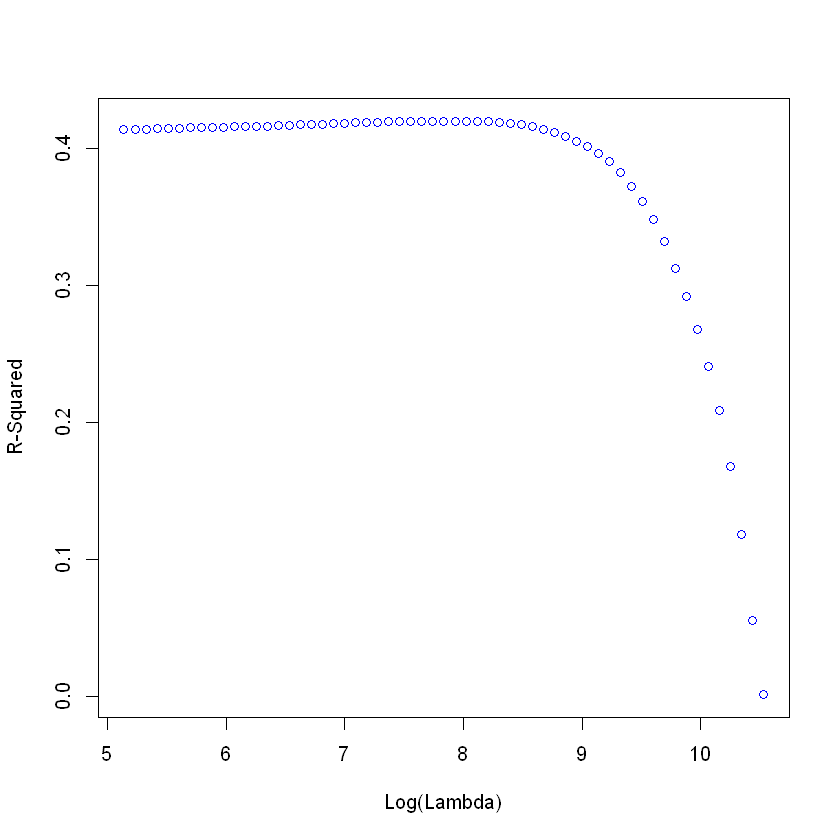

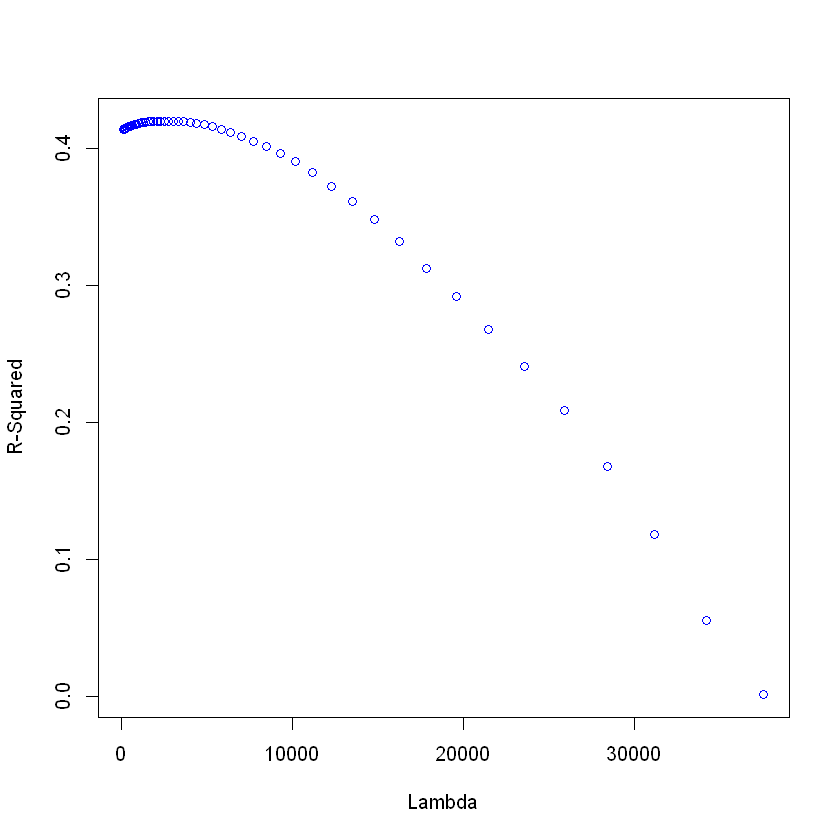

In [71]:
#Set seed for replication
set.seed(1)

#Function to calculate cross-validation errors for all lambda
cv_lasso <- cv.glmnet(as.matrix(x_train), y_train, alpha=1)

# Calculate the r-squared of the model for each lambda 
r2 <- 1 - cv_lasso$cvm/var(y_train) 
# Plots log(lambda) and R2
print("First graph is Log Lambda. Second is Lambda")
plot(log(cv_lasso$lambda), r2, xlab="Log(Lambda)", ylab="R-Squared", col="Blue")
plot(cv_lasso$lambda, r2, xlab="Lambda", ylab="R-Squared", col="Blue")

In [68]:
print("max R^2")
max(r2)
print("best Lambda")
best_lambda <- cv_lasso$lambda[which(r2==max(r2))] #stores the optimal lamda
best_lambda
print("log of best lambda")
log(best_lambda)

# Fit the Lasso model to the training data using the optimal lambda
lasso_model <- glmnet(as.matrix(x_train), y_train, alpha=1, lambda=best_lambda)

# Examine the coefficients
coef(lasso_model)
#x_train is matrix of covariates used to estimate the model, y_train is vector of outcome variable used in the estimation

[1] "max R^2"


[1] 0.4196193

[1] "best Lambda"


[1] 3044.209

[1] "log of best lambda"


[1] 8.020996

6 x 1 sparse Matrix of class "dgCMatrix"
                    s0
(Intercept) 19037.9242
gender        401.1573
age          -181.5371
urban       -6134.0696
income_1    16743.3384
liberal_1    6408.8928

In [79]:
# Run lasso with selected lambda on train and test set, get r-square for both
lasso_predict_in <- predict(lasso_train, s=best_lambda, newx = as.matrix(x_train))
lasso_predict_out <- predict(lasso_train, s=best_lambda, newx = as.matrix(x_test))

# Calculate r-square for lasso
print('Lasso In-sample R-squared')
1-mean((lasso_predict_in-y_train)^2)/var(y_train) 

[1] "Lasso In-sample R-squared"


[1] 0.5015232

In [80]:
print('Lasso Out-of-sample R-squared')
1-mean((lasso_predict_out-y_test)^2)/var(y_test)

[1] "Lasso Out-of-sample R-squared"


[1] 0.4117161